# Task -1 Anomaly detection
## Student ID1: 212174486 Nir Sasson
## Student ID2: 318658812 Yanir Cohen
### some notes: you can install Anaconda (python 3 prefered)
#### We will use Pandas, Numpy, and SKLEARN ( they are part of Anaconda distribution)
[GitHub](https://github.com/SassonNir/Anomaly_1)

In [1]:
# necessary libaries to run our program
!pip3 install oletools
!pip3 install scipy
!pip3 install numpy
!pip3 install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.font_manager
from sklearn.metrics import confusion_matrix,balanced_accuracy_score, plot_confusion_matrix,ConfusionMatrixDisplay
from sklearn.ensemble import IsolationForest
import pickle

## Read the data

In [3]:
# file path - this for linux windows you will need "//"
f_path = "./conn_attack.csv"
'''
record ID - The unique identifier for each connection record.
duration_  This feature denotes the number of seconds (rounded) of the connection. For example, a connection for 0.17s or 0.3s would be indicated with a “0” in this field.
src_bytes This field represents the number of data bytes transferred from the source to the destination (i.e., the amount of out-going bytes from the host).
dst_bytes This fea
ture represents the number of data bytes transferred from the destination to the source (i.e., the amount of bytes received by the host).
'''
df = pd.read_csv(f_path,names=["record ID","duration_", "src_bytes","dst_bytes"], header=None, index_col="record ID")

Get the head of the data

In [4]:
# Show the first rows of the data
df.head()

,duration_,src_bytes,dst_bytes
record ID,,,
1,0,236,1228
2,0,239,486
3,0,234,1364
4,0,239,1295
5,0,181,5450


In [5]:
# show the dimensions of the data
df.shape

(256670, 3)

In [6]:
# drop all null containing rows
df = df.dropna()

In [7]:
df.shape

(256670, 3)

## Data exploration

### Explore the data, understand the featues, statistics visualize the inputs
#### please try the following tools and extend them: this is for a soft start :) Explain how you explore the data. Why this is important? Please note this are only some examples


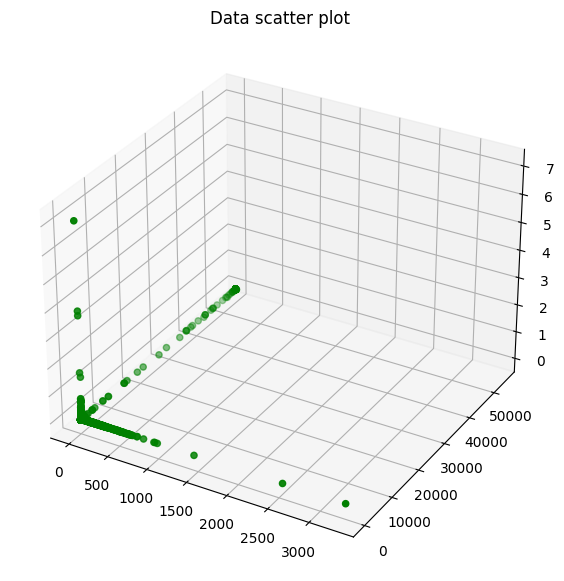

In [8]:
# Visualize the data in 3d in order to see what might be an anomaly
df_vis = pd.read_csv(f_path,names=["record ID","duration_", "src_bytes","dst_bytes"], header=None)
x = df_vis['duration_']
y = df_vis['src_bytes']
z = df_vis['dst_bytes'] 
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(x, y, z, color = "green")
plt.title("Data scatter plot")

# Anonating each point in order to visualise the data- this takes some time if you want to enable it
# There is a photo attached below

# for i, txt in enumerate(df_vis['record ID']):
#     ax.text(x[i],y[i], z[i],txt,size=5, zorder=1,  
#     color='k')
# show plot
plt.show()


# Results with record ID to show anomaly points clearly

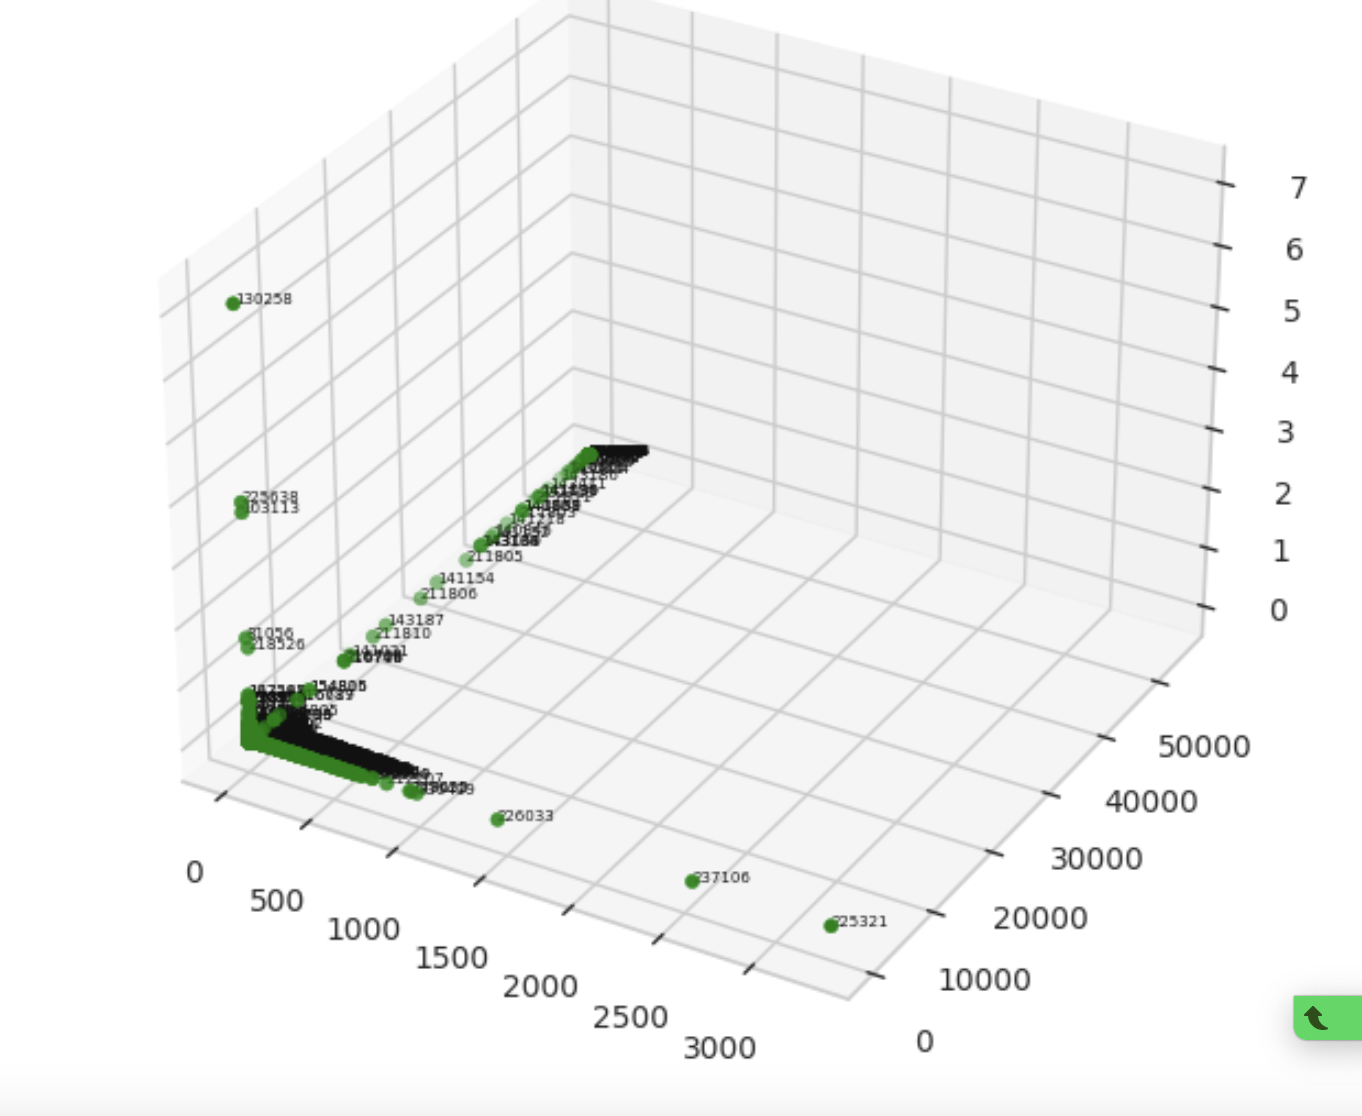

skew:
    
    In probability theory and statistics, skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean. The skewness value can be positive, zero, negative, or undefined.


In [9]:
'''
Deviate from the normal distribution.
Have appreciable positive skewness.
Show peakedness.
'''
#skewness and kurtosis for each column
for col in df.columns:
    print("Skewness: %f %s" % (df[col].skew(),col))
    print("Kurtosis: %f %s" % (df[col].kurt(),col)) # positive show long tail , negative light tail

Skewness: 74.033196 duration_
Kurtosis: 11208.320742 duration_
Skewness: 15.824471 src_bytes
Kurtosis: 248.739606 src_bytes
Skewness: 207.100418 dst_bytes
Kurtosis: 61028.785029 dst_bytes


correlation of the data frame
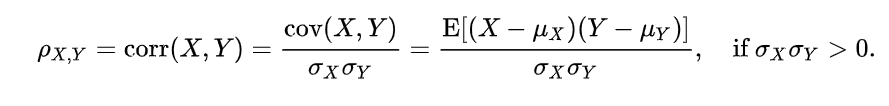


In [10]:
# pairwise correlation between the columns
df.corr()

,duration_,src_bytes,dst_bytes
duration_,1.000000,-0.001714,-0.005791
src_bytes,-0.001714,1.000000,0.010770
dst_bytes,-0.005791,0.010770,1.000000


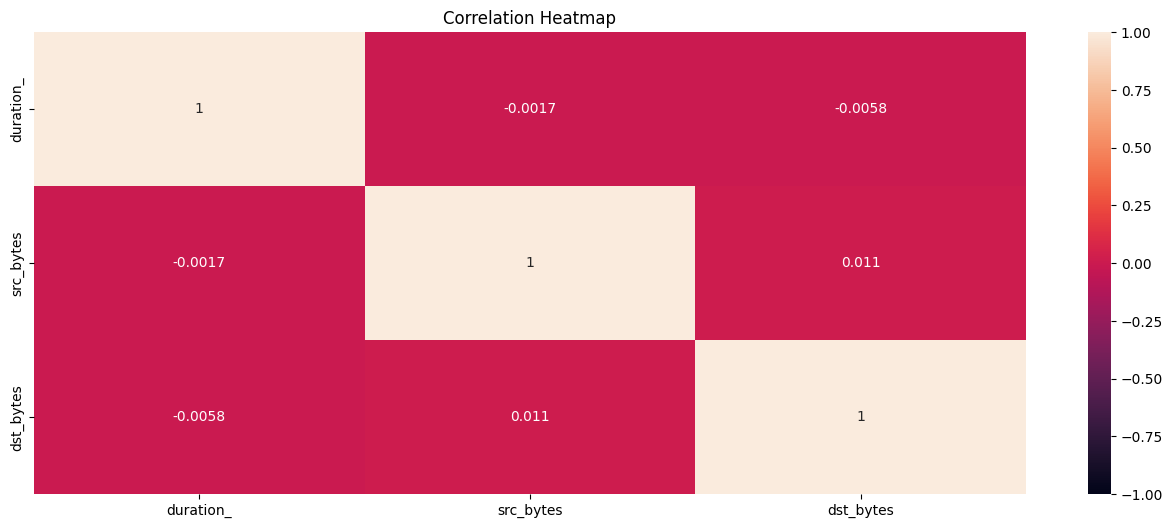

In [11]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12});

Summary of data exploration:

1) Did this help you?
    * Yes, the data visualiztion and exploration helped us notice the connection between the columns, on top of seeing what might be an anomaly in the 3D graph.
2) What did you find?
    * We found that there isn't high correlation between the columns meaning each feature stands by itself and might affect the answer to whether it is an anomaly
3) What the data exploration tell you about the data and the possible attacks?
    * Manifesting one of the features might trick a few models into not identifying whether a row is an attack, since they don't have many correlation between them. However, we have seen that the src bytes effect is the main contributer. to the anomaly factor. As a result multiple models might need to be trained and give the answers upon multiple models.
4) Which algorithms group is suitable for this task and why?
    * Unsupervised but more specifically clustering by using isolation forest.
    Clustering allows us to group features by aggregation and space division, which allows for the detection of outliers outside the norm.
5) What is the approach you tried? Why them?
    * Firstly we tried running a model that works. When we started getting the idea of it we experimented with multiple models seing what results we got. Then we decided to combine multiple models in order to solve the issue. Afterwards we couldn't decide which models to combine into one so we decided to go with the models which gave the best results (iForest).
6) How do you know the algorithm is good?
    * After analysing the results using different metrics such as balanaced anomaly score, confusion matrix and f1-score.

# Setup and train the model

In [12]:
# Setup the framework in order to train the model
# Get the results of the model
# Train the model
model=IsolationForest(n_estimators=50, max_samples='auto', contamination=0.01, \
                        max_features=3, bootstrap=False, n_jobs=-1, random_state=None, verbose=0)
model.fit(df[["duration_", "src_bytes","dst_bytes"]])
df['scores']=model.decision_function(df[["duration_", "src_bytes","dst_bytes"]])
df['Anomaly']=model.predict(df[["duration_", "src_bytes","dst_bytes"]])
df['Anomaly'] = df['Anomaly'].replace(1,0)
df['Anomaly'] = df['Anomaly'].replace(-1,1)
model_assign = df


/home/ec2-user/.local/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


In [13]:
df[df['Anomaly']==0].shape

(254103, 5)

In [14]:
df[df['Anomaly']==1].shape

(2567, 5)

In [15]:
# Get the true results (labels)
labels = pd.read_csv("./conn_attack_anomaly_labels.csv",names=["record ID","is_anomaly"],header=None)

In [16]:
# Merges the dataframe with the labels for further comparison
model_assign = model_assign.merge(labels,on = 'record ID')
model_assign.head()

,record ID,duration_,src_bytes,dst_bytes,scores,Anomaly,is_anomaly
0,1,0,236,1228,0.334180,0,0
1,2,0,239,486,0.326403,0,0
2,3,0,234,1364,0.334402,0,0
3,4,0,239,1295,0.326138,0,0
4,5,0,181,5450,0.248532,0,0


0.9940311113630067


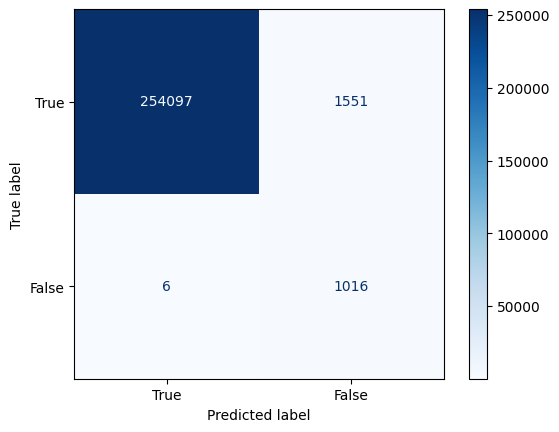

In [17]:
print(balanced_accuracy_score(model_assign["is_anomaly"],model_assign["Anomaly"]))
def confusion_ma(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred, normalize=None)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    return plt.show()

confusion_ma(model_assign["is_anomaly"],model_assign["Anomaly"], ["True", "False"])


In [18]:
# Saves the model
filename = 'iforest.sav'
pickle.dump(model, open(filename, 'wb'))
 

In [19]:
(model_assign.rename(columns={'Anomaly': 'is_anomaly?'})[['record ID', 'is_anomaly?']]).to_csv('results.csv', index=False)

# Machine Learning Algorithms

Please note that here you have to show AI/ML/DL algorithm. You can't use if else or "as we can see" text approach.\

# Summary and results

Use the label data I will provide to show if you menege to detect anomalies

# Create the final submission results

'''
What to submit?

record ID - The unique identifier for each connection record.
is_anomaly?_  This binary field indicates your detection result: 0 denotes the transmission is normal, 1 indicates anomalous.
Summary Report

'''